In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,Lasso,LassoCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,f_regression,SelectFromModel
from sklearn import metrics
import matplotlib.pyplot as plt
import xgboost
import pickle
import sqlite3
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import session
from sqlalchemy import create_engine, func

ModuleNotFoundError: No module named 'xgboost'

In [2]:
# Create connection with database file
dbfile = 'housedata.db'
con = sqlite3.connect(dbfile)

In [3]:
# Creating Cursor
cur = con.cursor()
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
# Print table list
print(table_list)

[('zip_code_database',), ('kc_house_data',), ('joined_table',)]


In [4]:
# Read in SQL query
df_housedata_raw = pd.read_sql_query('SELECT * FROM joined_table', con)

In [5]:
# List the column datatypes
df_housedata_raw.dtypes

zip                               object
type                              object
decommissioned                    object
primary_city                      object
acceptable_cities                 object
unacceptable_cities               object
state                             object
county                            object
timezone                          object
area_codes                        object
world_region                      object
country                           object
latitude                          object
longitude                         object
irs_estimated_population_2015      int64
id                                object
date                              object
price                              int64
bedrooms                           int64
bathrooms                         object
sqft_living                       object
sqft_lot                           int64
floors                           float64
waterfront                        object
view            

In [6]:
# list the column unique values
df_housedata_raw.nunique()

zip                                 70
type                                 1
decommissioned                       1
primary_city                        24
acceptable_cities                   18
unacceptable_cities                 46
state                                1
county                               1
timezone                             1
area_codes                          15
world_region                         1
country                              1
latitude                            37
longitude                           41
irs_estimated_population_2015       70
id                               21436
date                               372
price                             3610
bedrooms                            13
bathrooms                           30
sqft_living                       1038
sqft_lot                          9782
floors                               6
waterfront                           2
view                                 5
condition                

In [7]:
# Drop null rows if any
df_housedata_raw = df_housedata_raw.dropna()

# Check for 0 prices
df_housedata_raw = df_housedata_raw[df_housedata_raw["price"] != 0]

df_housedata_raw.head()

,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,98178,STANDARD,0.0,Seattle,Tukwila,"Bryn Mawr, Skyway",WA,King County,America/Los_Angeles,206253425.0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,98125,STANDARD,0.0,Seattle,,"Lake City, Northgate",WA,King County,America/Los_Angeles,206.0,...,7,2170,400,1951,1991,98125,47.721,-122.319,1690,7639
2,98028,STANDARD,0.0,Kenmore,Bothell,,WA,King County,America/Los_Angeles,425.0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,98136,STANDARD,0.0,Seattle,,Westwood,WA,King County,America/Los_Angeles,206.0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,98074,STANDARD,0.0,Sammamish,Redmond,,WA,King County,America/Los_Angeles,206425.0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [8]:
# Convert date to numeric
df_housedata_raw["sqft_living"] = pd.to_numeric(df_housedata_raw["sqft_living"])
df_housedata_raw["bathrooms"] = pd.to_numeric(df_housedata_raw["bathrooms"])
df_housedata_raw["view"] = pd.to_numeric(df_housedata_raw["view"])
df_housedata_raw["waterfront"] = pd.to_numeric(df_housedata_raw["waterfront"])

In [9]:
# Convert date to datetime format
df_housedata_raw["date"] = df_housedata_raw["date"].str[:4]
df_housedata_raw["date"] = pd.to_numeric(df_housedata_raw["date"])
df_housedata_raw["date"].value_counts()

2014    14599
2015     6837
Name: date, dtype: int64

In [10]:
# Calculate remodel age and sold age 
df_housedata_raw["yr_built"] = pd.to_numeric(df_housedata_raw["yr_built"])
df_housedata_raw["yr_renovated"] = pd.to_numeric(df_housedata_raw["yr_renovated"])
df_housedata_raw["SoldAge"] = df_housedata_raw["date"] - df_housedata_raw["yr_built"]
df_housedata_raw["RenovatedAge"] = df_housedata_raw["date"] - df_housedata_raw["yr_renovated"]
df_housedata_raw.head()

,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,SoldAge,RenovatedAge
0,98178,STANDARD,0.0,Seattle,Tukwila,"Bryn Mawr, Skyway",WA,King County,America/Los_Angeles,206253425.0,...,0,1955,0,98178,47.5112,-122.257,1340,5650,59,2014
1,98125,STANDARD,0.0,Seattle,,"Lake City, Northgate",WA,King County,America/Los_Angeles,206.0,...,400,1951,1991,98125,47.721,-122.319,1690,7639,63,23
2,98028,STANDARD,0.0,Kenmore,Bothell,,WA,King County,America/Los_Angeles,425.0,...,0,1933,0,98028,47.7379,-122.233,2720,8062,82,2015
3,98136,STANDARD,0.0,Seattle,,Westwood,WA,King County,America/Los_Angeles,206.0,...,910,1965,0,98136,47.5208,-122.393,1360,5000,49,2014
4,98074,STANDARD,0.0,Sammamish,Redmond,,WA,King County,America/Los_Angeles,206425.0,...,0,1987,0,98074,47.6168,-122.045,1800,7503,28,2015


In [11]:
# Drop columns not needed
df_housedata = df_housedata_raw.drop(columns = ["id","lat","long","sqft_living15","sqft_lot15",
                                                "date","yr_built","yr_renovated","zipcode",
                                               "zip","type","decommissioned","acceptable_cities","unacceptable_cities",
                                                "state","county","timezone","area_codes","world_region","country",
                                                "latitude","longitude","irs_estimated_population_2015"])

In [12]:
# # Label Encode for primary city
# le = LabelEncoder()
# df_housedata["primary_city"] = le.fit_transform(df_housedata["primary_city"])

In [13]:
# # One Hot Encoding for Primary City
# # Create a OneHotEncoder instance
# enc = OneHotEncoder(sparse=False)
# # Fit and transform the OneHotEncoder using the categorical variable list
# encode_df = pd.DataFrame(enc.fit_transform(df_housedata.primary_city.values.reshape(-1,1)))
# # Add the encoded variable names to the dataframe
# encode_df.columns = enc.get_feature_names(["primary_city"])
# encode_df.head()
# # Merge the two DataFrames together and drop the Country column
# df_housedata = df_housedata.merge(encode_df,left_index=True,right_index=True).drop("primary_city",1)

In [14]:
# Custom encode for primary city
# Rank cities by average price
average_price_rank = df_housedata.groupby("primary_city")["price"].mean().rank(axis=0, ascending=False)
average_price = df_housedata.groupby("primary_city")["price"].mean()
# Convert to dataframe
average_price_df = average_price_rank.to_frame(name="city_rank")
average_price_df["avg_price"] = average_price
average_price_df["avg_price"] = average_price_df["avg_price"].map("{:,.2f}".format)

# Merge rank with housedata and drop primary city
df_housedata = df_housedata.merge(average_price_df,on = "primary_city", how="left").drop(["primary_city","avg_price"],1)
df_housedata.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,SoldAge,RenovatedAge,city_rank
0,221900,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,59,2014,10.0
1,538000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,63,23,10.0
2,180000,2,1.00,770,10000,1.0,0,0,3,6,770,0,82,2015,14.0
3,604000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,49,2014,10.0
4,510000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,28,2015,4.0


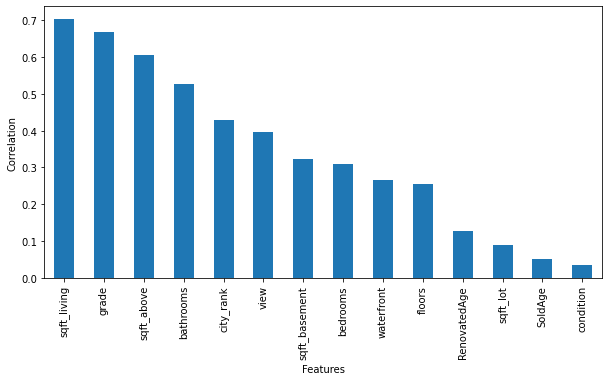

In [15]:
# Calculate Pearsons Correlation coefficient
housedata_corr_full = df_housedata.corr(method = "pearson")
housedata_corr = housedata_corr_full[["price"]].copy()
housedata_corr["price"] = abs(housedata_corr["price"])
housedata_corr = housedata_corr.drop(index="price")
housedata_corr = housedata_corr.sort_values(by=['price'],ascending=False)

# Plot the correlation results and download image
ax = housedata_corr.plot(kind ="bar",y="price",legend=False,figsize=(10,5))
ax.set_ylabel("Correlation")
ax.set_xlabel("Features", labelpad=5)
fig = ax.get_figure()
fig.savefig("static/styles/House_Price_Corr.png",bbox_inches = "tight")

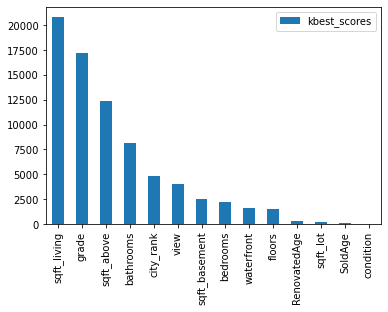

In [16]:
# Use Kbest to determine the features
# Convert dataset into X and Y
X_feature_sel = df_housedata.drop(["price"], axis = 1).copy()
Y_feature_sel = df_housedata["price"].copy()

# configure to select all features
fs = SelectKBest(score_func=f_regression, k='all')
# learn relationship from training data
fs.fit(X_feature_sel, Y_feature_sel)
# transform train input data
X_train_fs = fs.transform(X_feature_sel)

feature_name = list(X_feature_sel.columns)
housedata_kbest = pd.DataFrame(fs.scores_, columns=["kbest_scores"], index= feature_name)
housedata_kbest = housedata_kbest.sort_values(by=['kbest_scores'],ascending=False)
housedata_kbest.plot(kind ="bar",y="kbest_scores")

In [17]:
# selFeatures = SelectFromModel(Lasso(alpha=0.005,fit_intercept=False, tol=0.01))
# selFeatures.fit(X_feature_sel,Y_feature_sel)
# selected_feats = X_feature_sel.columns[(selFeatures.get_support())]
# features = selected_feats.to_list() 
# features

In [18]:
# Select features that have correlation greater that 0.5
sel_feature_pearsons = housedata_corr[housedata_corr["price"]>0.3].index.values.tolist()
sel_feature_pearsons

['sqft_living',
 'grade',
 'sqft_above',
 'bathrooms',
 'city_rank',
 'view',
 'sqft_basement',
 'bedrooms']

In [19]:
# Create X and Y datasets 
X = df_housedata[sel_feature_pearsons]
#X = df_housedata.drop(columns = "price").copy()
#X = df_housedata[["sqft_lot","sqft_living","bathrooms","bedrooms","city_rank","floors","grade"]]
y = df_housedata["price"]

# Splitting into Train and Test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y)

#Transforming y_train to log
y_train = np.log(y_train)

# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)
# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

Mean Absolute Error: 109227.81130325158
Root Mean Squared Error: 181240.99580517545
R_Squared: 0.7460867920889482


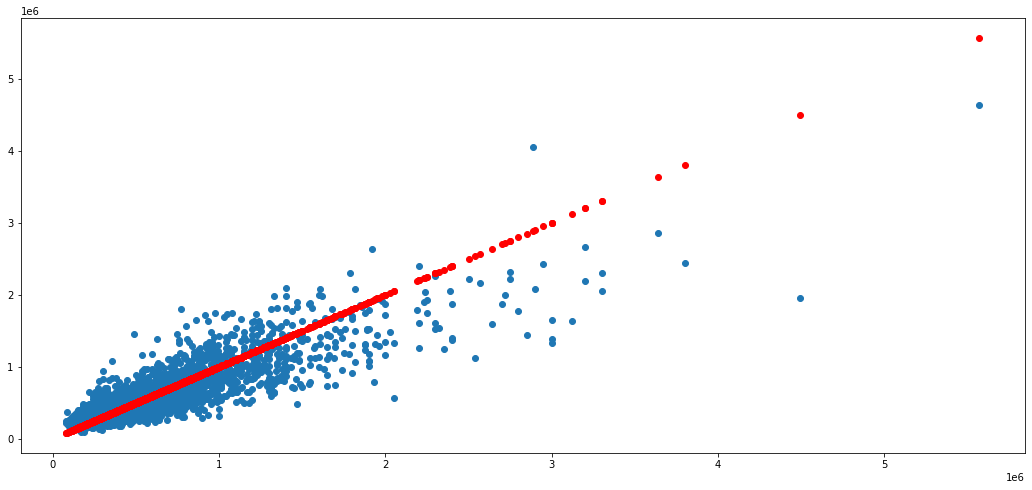

In [20]:
# Create a regressor model.
rf_model = RandomForestRegressor(n_estimators=500, random_state = 0) 
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)
# Making predictions using the testing data.
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_rf = np.exp(y_pred_rf)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rf))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))
print('R_Squared:', metrics.r2_score(y_test, y_pred_rf))

plt.figure(figsize=(18,8))
plt.scatter(y_test, y_pred_rf)
plt.scatter(y_test,y_test,color="red")

Mean Absolute Error: 103862.60400144616
Root Mean Squared Error: 172526.8347919334
R_Squared: 0.7699163689974862


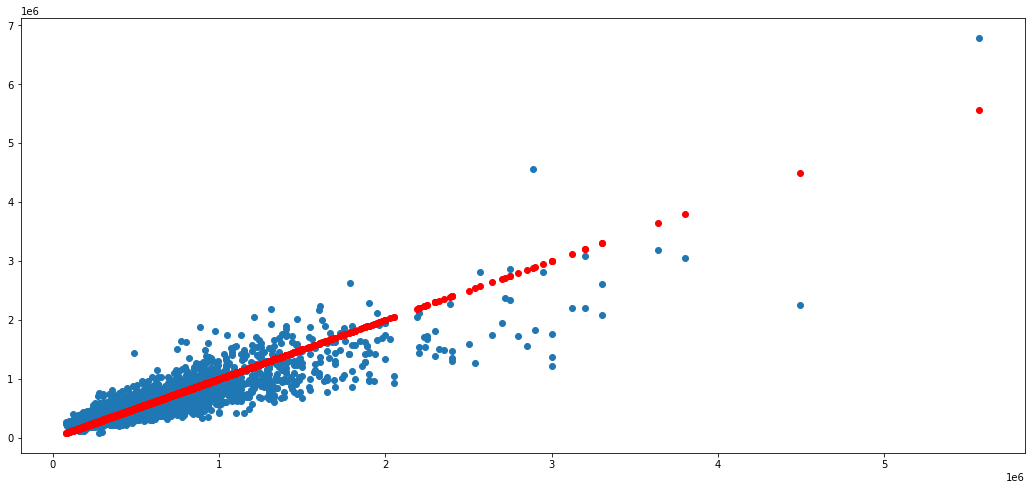

In [21]:
# Create a regressor model.
xgb_model = xgboost.XGBRegressor(learning_rate=0.05, max_depth=5,
                                 min_child_weight=1.5,n_estimators=500,subsample=0.8,seed=42)
# Fitting the model
xgb_model = xgb_model.fit(X_train_scaled, y_train)
# Making predictions using the testing data.
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_xgb = np.exp(y_pred_xgb)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_xgb))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgb)))
print('R_Squared:', metrics.r2_score(y_test, y_pred_xgb))

plt.figure(figsize=(18,8))
plt.scatter(y_test, y_pred_xgb)
plt.scatter(y_test,y_test,color="red")

Mean Absolute Error: 119563.18264494803
Root Mean Squared Error: 199330.7843135157
R_Squared: 0.6928707606539422


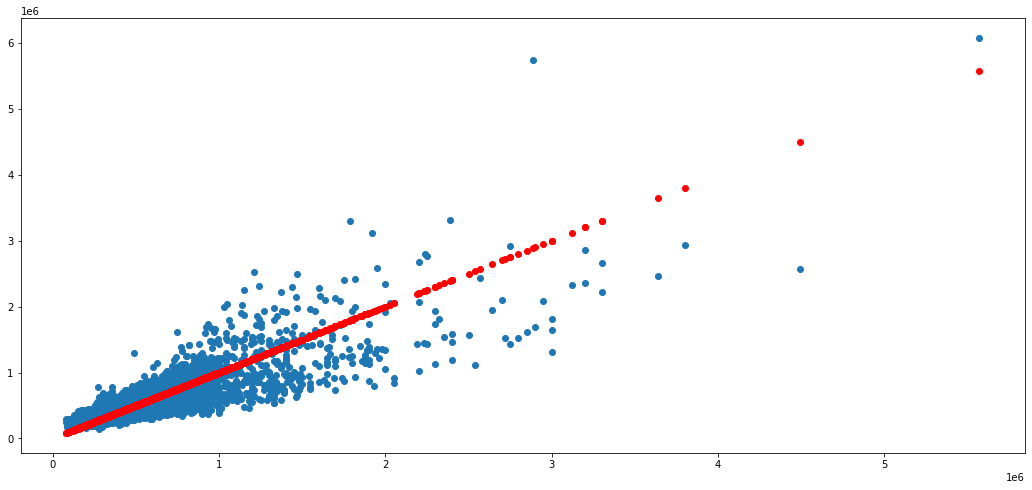

In [22]:
# Create a regressor model.
reg_model = LinearRegression()
# Fitting the model
reg_model = reg_model.fit(X_train_scaled, y_train)
# Making predictions using the testing data.
y_pred_reg = reg_model.predict(X_test_scaled)
y_pred_reg = np.exp(y_pred_reg)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_reg))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_reg)))
print('R_Squared:', metrics.r2_score(y_test, y_pred_reg))

plt.figure(figsize=(18,8))
plt.scatter(y_test, y_pred_reg)
plt.scatter(y_test,y_test,color="red")

In [23]:
# Compare the results from the three models and download the comparison file
compare_df = pd.DataFrame(y_pred_rf, columns = ["RF Prediction"])
compare_df["XGB Prediction"] = y_pred_xgb.tolist()
compare_df["Reg Prediction"] = y_pred_reg.tolist()
compare_df["Actual"] = y_test.tolist()
compare_df.to_csv("Compare.csv")
compare_df

,RF Prediction,XGB Prediction,Reg Prediction,Actual
0,1.191200e+06,1.088040e+06,1.235205e+06,887000
1,1.094557e+06,1.200942e+06,1.393606e+06,1090000
2,4.923884e+05,4.900644e+05,4.396262e+05,559950
3,4.242110e+05,3.784079e+05,3.866254e+05,608000
4,3.462746e+05,4.415754e+05,4.298566e+05,188500
...,...,...,...,...
5354,2.872050e+05,2.920147e+05,3.369589e+05,450000
5355,6.219224e+05,5.771292e+05,5.926935e+05,575000
5356,5.036300e+05,4.793589e+05,4.701029e+05,320000
5357,2.594409e+05,2.622953e+05,3.029109e+05,216000


In [24]:
# Download scalar and xgb model pickle file
pickle.dump(X_scaler,open("hp_scalar.pkl","wb"))
pickle.dump(xgb_model,open("hp_xgbmodel.pkl","wb"))

In [25]:
# Download formatted house data
df_housedata.to_csv("formatted_housedata.csv")
average_price_df.to_csv("average_price_df.csv")

In [26]:
# Features used 
# 'sqft_living',
# 'grade',
# 'sqft_above',
# 'bathrooms',
# 'city_rank',
# 'view',
# 'sqft_basement',
# 'bedrooms'

In [27]:
sqft_living = "1500"
grade = ""
sqft_above = ""
bathrooms = "2"
city = "Seattle"
view = ""
sqft_basement = ""
bedrooms = "3"

# get city_rank
city_rank = average_price_df.loc[average_price_df.index == city, "city_rank"].values[0]

# create the predict dataframe
pred_df = pd.DataFrame(columns = sel_feature_pearsons)
pred_df["sqft_living"] = [sqft_living]
pred_df["grade"] = grade
pred_df["sqft_above"] = sqft_above
pred_df["bathrooms"] = bathrooms
pred_df["city_rank"] = city_rank
pred_df["view"] = view
pred_df["sqft_basement"] = sqft_basement
pred_df["bedrooms"] = bedrooms

pred_df


,sqft_living,grade,sqft_above,bathrooms,city_rank,view,sqft_basement,bedrooms
0,1500,,,2,10.0,,,3


In [28]:
# fill in column values when no user input
# filter housedata for the city
predict_filler_df = df_housedata[df_housedata["city_rank"] == city_rank]


for column in pred_df:
    if pred_df.loc[0,column] == "":
        pred_df.loc[0,column] = predict_filler_df.groupby("city_rank")[column].mean().values[0]   
        
pred_df


,sqft_living,grade,sqft_above,bathrooms,city_rank,view,sqft_basement,bedrooms
0,1500,7.34571,1445.15,2,10.0,0.305434,352.745,3


In [29]:
#Predict House Price
pred_scaled = X_scaler.transform(pred_df)

y_pred_reg = reg_model.predict(pred_scaled)
y_pred_reg = np.exp(y_pred_reg)

y_pred_reg

array([437296.48269158])

In [30]:
y_pred_xgb = xgb_model.predict(pred_scaled)
y_pred_xgb = np.exp(y_pred_xgb)

y_pred_xgb

array([423327.4], dtype=float32)

In [31]:
y_pred_rf = rf_model.predict(pred_scaled)
y_pred_rf = np.exp(y_pred_rf)

y_pred_rf

array([412097.70769229])